# Tree Based Method Analysis

In [1]:
%pylab inline
import pandas as pd
import sklearn
from sklearn import ensemble # needed for random forest
import sklearn.tree
from sklearn.tree import DecisionTreeRegressor # from standard regression tree to test
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


## Read in data

In [2]:
# Read in Data
train = pd.read_csv("TrainingSet2.csv")
validation = pd.read_csv("ValidationSet2.csv")

In [3]:
# Drop entity condition variables
to_drop = ["Unnamed: 0", "entity_condition_1", "entity_condition_2", "entity_condition_3", "entity_condition_4"]
train.drop(to_drop, axis=1, inplace=True)
validation.drop(to_drop, axis=1, inplace=True)

In [4]:
# make things numbers
le = preprocessing.LabelEncoder()
for var in ["education", "sex", 'pod', 'marital_status', 'race', 'hispanic']:
    # do it for train
    le.fit(train[var])
    train[var] = le.transform(train[var])
    # do it for test
    le.fit(validation[var])
    validation[var] = le.transform(validation[var])

# Single Tree

In [157]:
# fit the single tree
reg_tree = DecisionTreeRegressor(max_depth=5)
reg_tree_fit = reg_tree.fit(train.drop(["age"], axis=1), train["age"])

In [159]:
# predict 
prediction = reg_tree_fit.predict(validation.drop(['age'], axis=1))
truth = validation["age"]
np.mean( (truth-prediction)**2 ) # MSE

125.03155851750459

In [190]:
# Run over various depts
errors = []
depths = range(1,30, 5)
for depth in depths:
    print "testing depth: ", depth
    # fit
    reg_tree = DecisionTreeRegressor(max_depth=depth)
    reg_tree_fit = reg_tree.fit(train.drop(["age"], axis=1), train["age"])
    # predict
    prediction = reg_tree_fit.predict(validation.drop(['age'], axis=1))
    truth = validation["age"]
    errors.append(np.mean( (truth-prediction)**2 )) # MSE

testing depth:  1
testing depth:  6
testing depth:  11
testing depth:  16
testing depth:  21
testing depth:  26


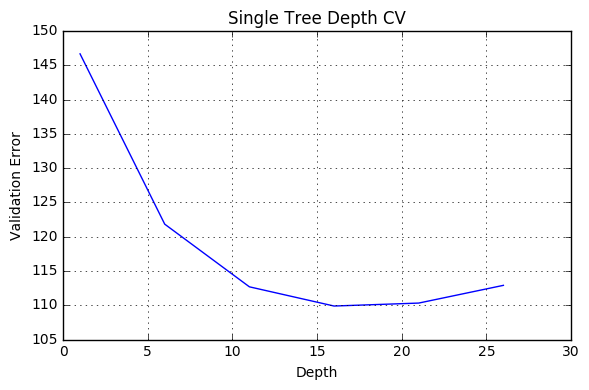

In [204]:
plt.plot(depths, errors) 
plt.title("Single Tree Depth CV")
plt.xlabel("Depth")
plt.ylabel("Validation Error")
plt.grid()
#plt.savefig("SingleTreeCV.png")
plt.show()

In [161]:
# Read in test set
test = pd.read_csv("TestSet2.csv")

# Drop entity condition variables
to_drop = ["Unnamed: 0", "entity_condition_1", "entity_condition_2", "entity_condition_3", "entity_condition_4"]
test.drop(to_drop, axis=1, inplace=True)

# Make appropriate factors
le = preprocessing.LabelEncoder()
for var in ["education", "sex", 'pod', 'marital_status', 'race', 'hispanic']:
    le.fit(test[var])
    test[var] = le.transform(test[var])

In [5]:
# Fit depth 15 tree
reg_tree = DecisionTreeRegressor(max_depth=15)
reg_tree_fit = reg_tree.fit(train.drop(["age"], axis=1), train["age"])

In [25]:
# Reduction in GINI coefficients
reduction_list = []
cols = train.drop(["age"], axis=1).columns
for i in range(train.shape[1] -1):
    reduction_list.append( (cols[i], reg_tree_fit.feature_importances_[i]))
# sort it
reduction_list = sorted(reduction_list, key=lambda x: x[1], reverse= True)
reduction_list

[('marital_status', 0.60928478163446231),
 ('pod', 0.10912822112177963),
 ('F03', 0.034739714930278234),
 ('G30', 0.033578972401415913),
 ('I50', 0.029976154617925393),
 ('sex', 0.025061261502285045),
 ('race', 0.023488518651307671),
 ('F10', 0.019103317098154129),
 ('education', 0.017933084590004499),
 ('K70', 0.0092877437142526234),
 ('C50', 0.0076193614358282691),
 ('I48', 0.0075778379391031542),
 ('R99', 0.0075552069868056338),
 ('C34', 0.0062579683923130814),
 ('C71', 0.0052098595850867992),
 ('J44', 0.0042948972325869616),
 ('K74', 0.0039553590109639922),
 ('R54', 0.0038090134532848424),
 ('C53', 0.0035208217095959631),
 ('E14', 0.0032846382241763028),
 ('hispanic', 0.0031597318603746667),
 ('G20', 0.0026994006795560636),
 ('I11', 0.002531887837465665),
 ('I25', 0.0025031660236414389),
 ('I64', 0.0018069802608948137),
 ('R56', 0.0014853654429084573),
 ('G93', 0.0012770040372262483),
 ('C61', 0.0012705126961728378),
 ('I67', 0.0011038960703912927),
 ('I42', 0.0010422579611883171),

In [200]:
# Predict and Evaluate
prediction = reg_tree_fit.predict(test.drop(['age'], axis=1))
truth = test["age"]
single_mse = np.mean( (prediction - truth)**2 )
single_mae = np.mean( np.abs(prediction - truth) )

print "Single Tree MSE:", single_mse
print "Single Tree MAE:", single_mae

Single Tree MSE: 116.7674538
Single Tree MAE: 8.27662320238


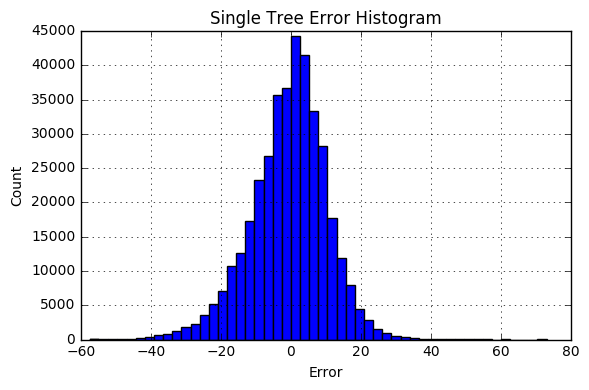

In [205]:
# Make a histogram of errors
plt.hist((truth - prediction), bins=50)
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Single Tree Error Histogram")
plt.grid()
#plt.savefig("SingleTree_Error_Hist.png")
plt.show()

In [202]:
# Get error quantiles
print "25th Error Percentile:", round(np.percentile((truth - prediction), 25), 2)
print "75th Error Percentile:", round(np.percentile((truth - prediction), 75), 2)

25th Error Percentile: -6.89
75th Error Percentile: 6.2


# Random Forest

In [5]:
# Fit an inital single random forest
rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 3) # number trees in forest = 50
rf_fit = rf.fit(train.drop(["age"], axis=1), train["age"])

# Predict 
prediction = rf.predict(validation.drop(['age'], axis=1))
np.mean( (validation["age"] - prediction)**2 )

124.68506315369329

We now want to cross validate across not only the number of trees grown (n_estimators) as well as the number of features allowed at each split (max_features). Number of trees should probably go from 10-100, and number of features should be in the range of 5-100 as well. Ideally you would cross validate over both at once

In [168]:
# Make smaller sets for cross validataion so takes reasonable time
mini_train, mini_validation = np.split(train, [int(train.shape[0]*.1)])

In [169]:
# Fit an inital single random forest (on this smaller set just to test it)
rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 3) # number trees in forest = 50
rf_fit = rf.fit(mini_train.drop(["age"], axis=1), mini_train["age"])

# Predict 
prediction = rf.predict(mini_validation.drop(['age'], axis=1))
np.mean( (mini_validation["age"] - prediction)**2 )

144.2284451596429

In [170]:
num_trees = [5, 10, 25, 50, 75, 100]
num_tree_error = []
for n in num_trees:
    print "Fitting with", n, "trees"
    # Fit an inital single random forest
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators = n) # number trees in forest = 50
    rf_fit = rf.fit(mini_train.drop(["age"], axis=1), mini_train["age"])

    # Predict 
    prediction = rf.predict(mini_validation.drop(['age'], axis=1))
    num_tree_error.append(np.mean( (mini_validation["age"] - prediction)**2 ))

Fitting with 5 trees
Fitting with 10 trees
Fitting with 25 trees
Fitting with 50 trees
Fitting with 75 trees
Fitting with 100 trees


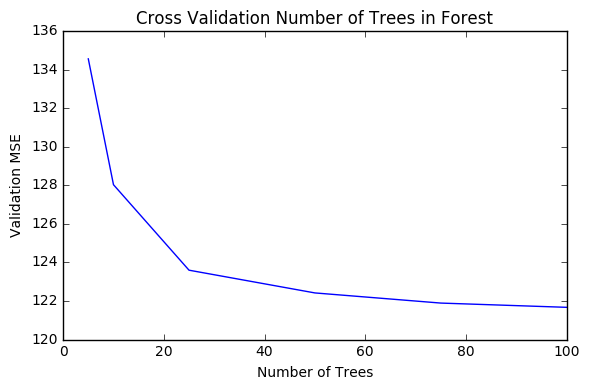

In [171]:
plt.plot(num_trees, num_tree_error)
plt.xlabel("Number of Trees")
plt.ylabel("Validation MSE")
plt.title("Cross Validation Number of Trees in Forest")
plt.show()

That ROUGH estimate would lead me to think 50 trees?

Now lets take a look at the number of features

In [172]:
num_features = [1, 2, 3, 4, 5, 10]
num_features_error = []
for f in num_features:
    print "Fitting with", f, "features"
    # Fit an inital single random forest
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 50, max_features=f) # number trees in forest = 50
    rf_fit = rf.fit(mini_train.drop(["age"], axis=1), mini_train["age"])

    # Predict 
    prediction = rf.predict(mini_validation.drop(['age'], axis=1))
    num_features_error.append(np.mean( (mini_validation["age"] - prediction)**2 ))

Fitting with 1 features
Fitting with 2 features
Fitting with 3 features
Fitting with 4 features
Fitting with 5 features
Fitting with 10 features


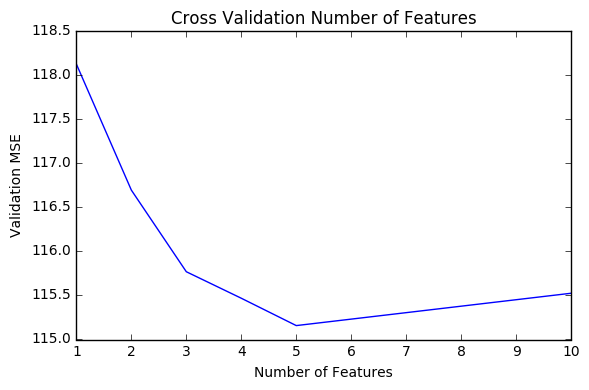

In [173]:
plt.plot(num_features, num_features_error)
plt.xlabel("Number of Features")
plt.ylabel("Validation MSE")
plt.title("Cross Validation Number of Features")
plt.show()

In [174]:
train.shape

(764461, 110)

Lets try to set up a grid accross which to cross validate, take only a few values from each of the previous cross validations and check all possible combos, save the best

In [175]:
a = np.random.rand(2,3)
a

array([[ 0.92884626,  0.7987438 ,  0.24932851],
       [ 0.12661005,  0.08859952,  0.70283824]])

In [176]:
best_num_trees = 0
best_num_features = 0
best_error = np.Infinity
#num_trees = [70, 80, 90, 100, 120, 150, 200]
num_trees = [70, 80, 90, 100, 110, 120, 130, 150, 170, 200]
#num_features = [3, 6, 9, 12, 15]
num_features = [3, 4, 5, 6, 7, 9, 12, 15]
grid_errors = np.zeros([len(num_trees), len(num_features)])
for t in range(len(num_trees)):
    for f in range(len(num_features)):
        print "fitting with", num_trees[t], "trees and", num_features[f], "features"
        # Fit an inital single random forest
        rf = sklearn.ensemble.RandomForestRegressor(n_estimators = num_trees[t],
                                                    max_features=num_features[f]) # number trees in forest = 50
        rf_fit = rf.fit(mini_train.drop(["age"], axis=1), mini_train["age"])

        # Predict 
        prediction = rf.predict(mini_validation.drop(['age'], axis=1))
        mse = np.mean( (mini_validation["age"] - prediction)**2 )
        
        # Save and check
        grid_errors[t,f] = mse
        if mse < best_error:
            best_error = mse
            best_num_trees = num_trees[t]
            best_num_features = num_features[f]
            
print "Best Error:", best_error
print "Best Number of Trees:", best_num_trees
print "Best Number of Features:", best_num_features

fitting with 70 trees and 3 features
fitting with 70 trees and 4 features
fitting with 70 trees and 5 features
fitting with 70 trees and 6 features
fitting with 70 trees and 7 features
fitting with 70 trees and 9 features
fitting with 70 trees and 12 features
fitting with 70 trees and 15 features
fitting with 80 trees and 3 features
fitting with 80 trees and 4 features
fitting with 80 trees and 5 features
fitting with 80 trees and 6 features
fitting with 80 trees and 7 features
fitting with 80 trees and 9 features
fitting with 80 trees and 12 features
fitting with 80 trees and 15 features
fitting with 90 trees and 3 features
fitting with 90 trees and 4 features
fitting with 90 trees and 5 features
fitting with 90 trees and 6 features
fitting with 90 trees and 7 features
fitting with 90 trees and 9 features
fitting with 90 trees and 12 features
fitting with 90 trees and 15 features
fitting with 100 trees and 3 features
fitting with 100 trees and 4 features
fitting with 100 trees and 5 f

Now do a 3D plot to visualize that (just for fun)

In [177]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

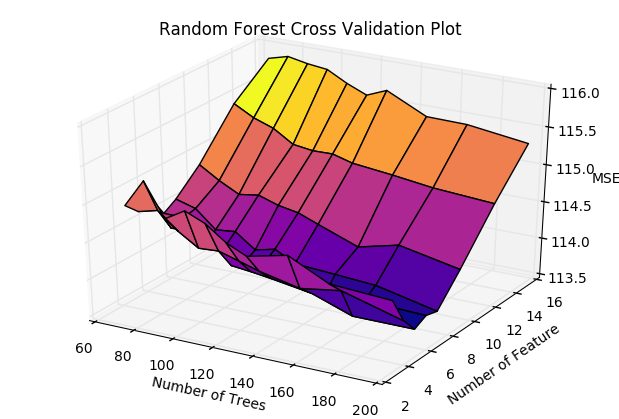

In [178]:
xs, ys = np.meshgrid(num_trees, num_features)
fig = plt.figure()
ax = Axes3D(fig)
#ax.plot_surface(xs, ys, grid_errors, rstride=1, cstride=1, cmap='plasma')
ax.plot_surface(xs, ys, np.transpose(grid_errors), rstride=1, cstride=1, cmap='plasma')
plt.xlabel("Number of Trees")
plt.ylabel("Number of Feature")
plt.title("Random Forest Cross Validation Plot")
ax.set_zlabel("MSE")
#fig.tight_layout()
#fig.subplots_adjust(bottom=.025)
#plt.savefig("RF_CrossValidationPlot.png")
plt.show()

The above plot is great, but if you need to recreate it, copy and paste the data into terminal and re-create the plot, otherwise the figure from the jupyter notebook cuts of part of the lower axis.

# Fit the Final Random Forest
Looking at the above cross validation I will choose 120 Trees for the forest, as the marginal returns after that are insignificant, and 6 features to choose from per split, as that is clearly the best choice (across all sizes of forest even). I will Train on all the training data and test to get a final score on the test set.

In [26]:
# Fit the large forest
rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 120, max_features=5)
rf_fit = rf.fit(train.drop(["age"], axis=1), train["age"])

In [34]:
# Reduction in GINI coefficients
rf_reduction_list = []
cols = train.drop(["age"], axis=1).columns
reductions = rf_fit.feature_importances_
for i in range(train.shape[1] -1):
    rf_reduction_list.append( (cols[i], reductions[i]))
# sort it
rf_reduction_list = sorted(rf_reduction_list, key=lambda x: x[1], reverse= True)
rf_reduction_list

[('marital_status', 0.27216900834066393),
 ('pod', 0.095159880530829508),
 ('education', 0.080289502024655526),
 ('race', 0.037269552894680466),
 ('F03', 0.028365605237950894),
 ('G30', 0.025915849420740336),
 ('sex', 0.024704706971631463),
 ('I50', 0.021247686463491032),
 ('hispanic', 0.020693417426248931),
 ('I46', 0.017308173879943087),
 ('F10', 0.015575186521490881),
 ('J96', 0.011578553478657634),
 ('I25', 0.011305833304746372),
 ('I10', 0.010159942211138147),
 ('I48', 0.0093182157846761135),
 ('J44', 0.0086956371387271296),
 ('K70', 0.0086274990694783418),
 ('C50', 0.0083404906530043735),
 ('E14', 0.0082187326184724168),
 ('N18', 0.0081671561926255146),
 ('K74', 0.007869981469560746),
 ('C34', 0.0077954073233083053),
 ('I21', 0.007671801111019021),
 ('A41', 0.0076358898556757177),
 ('J18', 0.007438472919576682),
 ('I11', 0.0073187924924211448),
 ('R09', 0.0070511957978767288),
 ('K76', 0.0068082036826102293),
 ('R99', 0.0067570290438296104),
 ('R54', 0.0065439895556913159),
 ('I6

In [181]:
# Read in test set
test = pd.read_csv("TestSet2.csv")

# Drop entity condition variables
to_drop = ["Unnamed: 0", "entity_condition_1", "entity_condition_2", "entity_condition_3", "entity_condition_4"]
test.drop(to_drop, axis=1, inplace=True)

# Make appropriate factors
le = preprocessing.LabelEncoder()
for var in ["education", "sex", 'pod', 'marital_status', 'race', 'hispanic']:
    le.fit(test[var])
    test[var] = le.transform(test[var])

In [207]:
# Predict the large forest
prediction = rf.predict(test.drop(['age'], axis=1))
mse = np.mean( (test["age"] - prediction)**2 )
mae = np.mean( np.abs(test["age"] - prediction))
print "Random Forest MSE:", mse
print "Random Forest MAE:", mae

Random Forest MSE: 113.757779371
Random Forest MAE: 8.16966053842


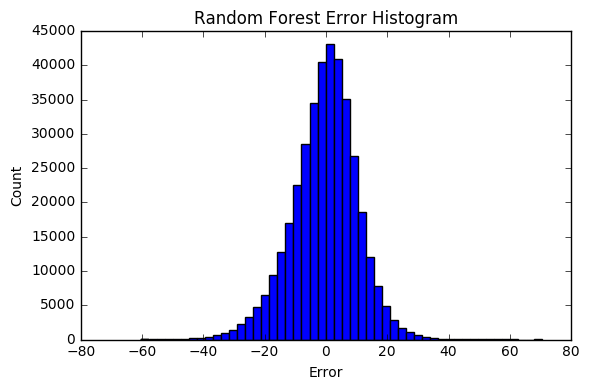

In [209]:
# Make a histogram of errors
plt.hist((test["age"] - prediction), bins=50)
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Random Forest Error Histogram")
plt.savefig("RF_Error_Hist.png")
plt.show()

In [210]:
# Get error quantiles
print "25th Error Percentile:", round(np.percentile((test["age"] - prediction), 25), 2)
print "75th Error Percentile:", round(np.percentile((test["age"] - prediction), 75), 2)

25th Error Percentile: -6.71
75th Error Percentile: 6.28
